In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Learning in Repeated Advertising Auctions

## Click Visualization Model

### Important Quantities
### Given and ad $a$ and a slot $s$, each time $t$ a user arrives:
- ### $\lambda_s$: probability that the slot $s$ is observed by the user (slot prominence)
- ### $q_a$: probability that the ad is clicked ***given that the user has seen it*** (ad quality)
- ### $v_a$: ad's profit per click (ad value)

### Assumptions of this model:
- ### All the quantities are **fixed** and don't vary with time.
- ### Ad's quality $q_a$ and profit-per-click $v_a$ don't depend on the slot.
- ### Prominence $\lambda_s$ doesn't depend on the ad.

In [5]:
class Auction:
    def __init__(self, *args, **kwargs):
        pass

    def get_winners(self, bids):
        pass

    def get_payments_per_click(self, winners, values, bids):
        pass

    def round(self, bids):
        winners, values = self.get_winners(bids) # allocation mechanism!
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click


# Truthful Auctions

## Publisher's Perspective

### Single slot

In [6]:
class SecondPriceAuction(Auction):
    def __init__(self, qs):
        self.qs = qs
        self.n_adv = len(self.qs)
    
    def get_winners(self, bids):
        adv_values = self.qs*bids
        adv_ranking = np.argsort(adv_values)
        winner = adv_ranking[-1]
        return winner, adv_values
    
    def get_payments_per_click(self, winners, values, bids):
        adv_ranking = np.argsort(values)
        second = adv_ranking[-2]
        payment = values[second]/self.qs[winners]
        return payment.round(2)

In [7]:
# advertisers' fixed parameters
n_adv = 4 # four advertisers
qs = np.array([0.8, 0.65, 0.50, 0.75])
v = np.array([0.7, 1.1, 1.4, 0.85])

# environmental settings
n_users= 3

auction = SecondPriceAuction(qs=qs)
for u in range(n_users):
    print(f'# User {u}')
    bids = np.random.choice([0.25, 0.5, 0.75, 1], size=n_adv)
    pub_values = bids*qs
    print(f'Bids: {bids}, Publisher Values: {pub_values}')
    winner, payment_per_click = auction.round(bids=bids)
    print(f'Auction Winner: {winner}, Payment-per-click: {payment_per_click}')
    print(f'Payment <= Bid : {payment_per_click <= bids[winner]}')


# User 0
Bids: [0.25 0.25 0.25 0.5 ], Publisher Values: [0.2    0.1625 0.125  0.375 ]
Auction Winner: 3, Payment-per-click: 0.27
Payment <= Bid : True
# User 1
Bids: [0.5  0.75 0.25 0.25], Publisher Values: [0.4    0.4875 0.125  0.1875]
Auction Winner: 1, Payment-per-click: 0.62
Payment <= Bid : True
# User 2
Bids: [0.5  0.25 1.   0.25], Publisher Values: [0.4    0.1625 0.5    0.1875]
Auction Winner: 2, Payment-per-click: 0.8
Payment <= Bid : True


### Multiple Slots

In [8]:
class VCGAuction(Auction):
    def __init__(self, qs, lambdas):
        self.qs = qs
        self.lambdas = lambdas
        self.n_adv = len(self.qs)
        self.n_slots = len(self.lambdas)

    def get_winners(self, bids):
        adv_values = self.qs*bids
        adv_ranking = np.argsort(adv_values)
        winners = adv_ranking[-self.n_slots:]
        winners_values = adv_values[winners]
        return winners, winners_values
    
    def get_payments_per_click(self, winners, values, bids):
        payments_per_click = np.zeros(self.n_slots)
        for i,w in enumerate(winners):
            Y = sum(np.delete(values, i)*self.lambdas[-self.n_slots+1:])
            X = sum(np.delete(values*self.lambdas, i))
            payments_per_click[i] = (Y-X)/(self.lambdas[i]*self.qs[w])
        return payments_per_click.round(2)

In [9]:
# publisher's fixed parameters
n_slots = 3
lmbd = np.array([0.4, 0.6, 0.8]) # assumed to be decreasing

# advertisers' fixed parameters
n_adv = 4 # four advertisers
qs = np.array([0.8, 0.65, 0.50, 0.75])
v = np.array([0.7, 1.1, 1.4, 0.85])

# environmental settings
n_users= 10

auction = VCGAuction(qs=qs, lambdas=lmbd)
for u in range(n_users):
    print(f'# User {u}')
    bids = np.random.choice([0.25, 0.5, 0.75, 1], size=n_adv)
    pub_values = bids*qs
    print(f'Bids: {bids}, Publisher Values: {pub_values}')
    winners, payments_per_click = auction.round(bids=bids)
    print(f'Auction Winners: {winners}, Payment-per-click: {payments_per_click}')
    print(f'Payment <= Bid : {(payments_per_click <= bids[winners]).all()}')


# User 0
Bids: [1.   0.5  0.25 0.75], Publisher Values: [0.8    0.325  0.125  0.5625]
Auction Winners: [1 3 0], Payment-per-click: [0.   0.14 0.28]
Payment <= Bid : True
# User 1
Bids: [0.75 0.5  0.25 0.25], Publisher Values: [0.6    0.325  0.125  0.1875]
Auction Winners: [3 1 0], Payment-per-click: [0.   0.1  0.16]
Payment <= Bid : True
# User 2
Bids: [0.75 0.25 0.75 0.5 ], Publisher Values: [0.6    0.1625 0.375  0.375 ]
Auction Winners: [2 3 0], Payment-per-click: [0.   0.17 0.23]
Payment <= Bid : True
# User 3
Bids: [1. 1. 1. 1.], Publisher Values: [0.8  0.65 0.5  0.75]
Auction Winners: [1 3 0], Payment-per-click: [0.   0.29 0.44]
Payment <= Bid : True
# User 4
Bids: [0.75 0.5  0.75 0.25], Publisher Values: [0.6    0.325  0.375  0.1875]
Auction Winners: [1 2 0], Payment-per-click: [0.   0.22 0.22]
Payment <= Bid : True
# User 5
Bids: [0.25 1.   0.25 0.25], Publisher Values: [0.2    0.65   0.125  0.1875]
Auction Winners: [3 0 1], Payment-per-click: [0.   0.08 0.15]
Payment <= Bid : T

## Advertiser's Perspective: learning in repeated second price auctions

#### We will assume, from now on, that all CTRs are equal to 1.

#### What is the best **and feasible** sequence of bids I can do? How much cumulative utility does a clairvoyant gain?

In [10]:
### Deterministic Bidders: my competitors always bid the same amount until budget depletion

n_advertisers = 3 # 4 including myself
n_users = 1000
B = 50

# simple scenario: competitors fix their bids
other_bids = np.repeat(np.array([0.2,0.5,0.7]).reshape(-1,1), n_users, axis=1)
## budget depletes after B/bid rounds 
# # (this is even simpler: I assume budget depleted even when the advertiser does not win the auction)
other_bids[0,int(B/0.2):] = 0
other_bids[1,int(B/0.5):] = 0
other_bids[2,int(B/0.7):] = 0
# easy scenario: I assume competitors to have the same budget as mine (they could have more in practica)
# and that they behave greedily, always bidding until budget depletion

m_t = other_bids.max(axis=0) ## highest bid at each round

### The actuion is truthful: why not just bidding my true value?

<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:32: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:32: SyntaxWarning: invalid escape sequence '\s'
C:\Users\matteo\AppData\Local\Temp\ipykernel_15812\3643127052.py:26: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum m_t~ 1_{b_t > m_t}$')
C:\Users\matteo\AppData\Local\Temp\ipykernel_15812\3643127052.py:32: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum (v_t-m_t) ~ 1_{b_t > m_t}$')


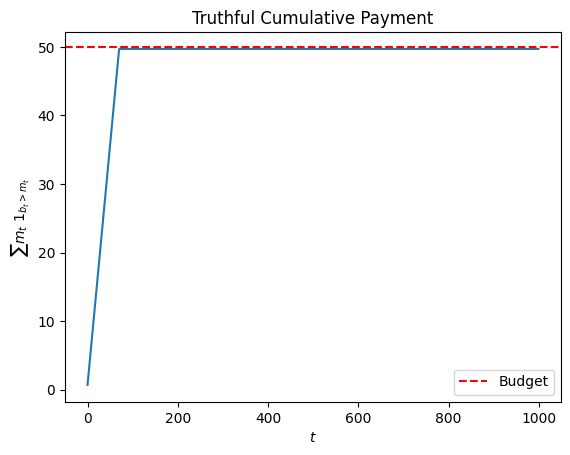

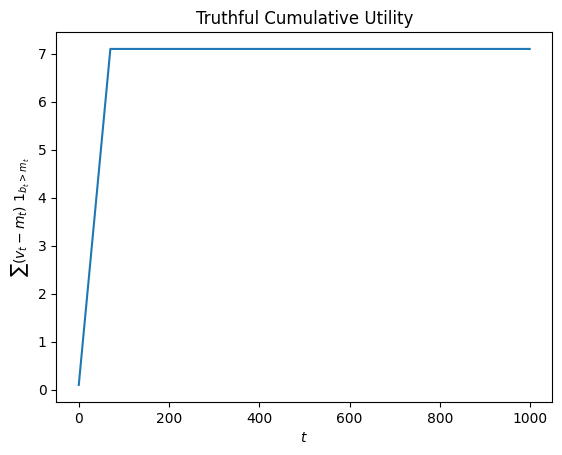

In [11]:
B = 50
ctr = 1
value_per_click = 0.8

truthful_bids = np.zeros(n_users)
truthful_utilities = np.zeros(n_users)
truthful_payments = np.zeros(n_users)
depleted_budget = 0
last_bid_round = n_users - 1
for u in range(n_users):
    truthful_bids[u] = value_per_click
    truthful_payments[u] = m_t[u] if value_per_click>=m_t[u] else 0
    truthful_utilities[u] = value_per_click - m_t[u] if value_per_click>=m_t[u] else 0
    depleted_budget += truthful_payments[u]
    if B - depleted_budget < value_per_click:
        last_bid_round = u
        break
# obs: I am not winning the ties if everybody bids 0
# truthful_utilities[m_t==0] = value_per_click

plt.title('Truthful Cumulative Payment')
plt.plot(np.cumsum(truthful_payments))
plt.axhline(B, color='red', linestyle='--', label='Budget')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$\sum m_t~ 1_{b_t > m_t}$')
plt.show()

plt.title('Truthful Cumulative Utility')
plt.plot(np.cumsum(truthful_utilities))
plt.xlabel('$t$')
plt.ylabel('$\sum (v_t-m_t) ~ 1_{b_t > m_t}$')
plt.show()


### Can we do better?

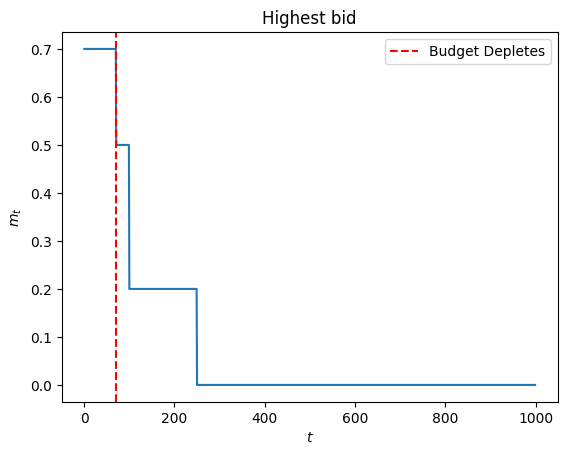

In [12]:
plt.title("Highest bid")
plt.plot(m_t)
plt.axvline(last_bid_round, color='red', linestyle='--', label='Budget Depletes')
plt.xlabel('$t$')
plt.ylabel('$m_t$')
plt.legend()
plt.show()

### If I do not bid in the initial rounds, I can increase my utility.

### **Remark**: truthful auctions incentivize to bid the true valuation if there is not budget constrait. With a finite budget, this is no longer the best strategy. 

### I know, for each round, what will be the highest bid. Now I have to solve an optimization problem and find out how to allocate my bids optimally.

In [13]:
### As a re-usable function:
def get_clairvoyant_truthful(B, my_valuation, m_t, n_users):
    ## I compute my sequence of utilities at every round
    utility = (my_valuation-m_t)*(my_valuation>=m_t)
    ## Now I have to find the sequence of m_t summing up to budget B and having the maximum sum of utility
    ## In second price auctions, I can find the sequence **greedily**:
    sorted_round_utility = np.flip(np.argsort(utility)) # sorted rounds, from most profitable to less profitable
    clairvoyant_utilities = np.zeros(n_users)
    clairvoyant_bids= np.zeros(n_users)
    clairvoyant_payments = np.zeros(n_users)
    c = 0
    i = 0
    while c <= B-1 and i < n_users and utility[sorted_round_utility[i]]>=0:
        clairvoyant_bids[sorted_round_utility[i]] = 1
        clairvoyant_utilities[sorted_round_utility[i]] = utility[sorted_round_utility[i]]
        clairvoyant_payments[sorted_round_utility[i]] = m_t[sorted_round_utility[i]]
        c += m_t[sorted_round_utility[i]]
        i+=1
    return clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments

<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\s'
C:\Users\matteo\AppData\Local\Temp\ipykernel_15812\1278304834.py:14: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum m_t~ 1_{b_t > m_t}$')
C:\Users\matteo\AppData\Local\Temp\ipykernel_15812\1278304834.py:30: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum (v_t-m_t) ~ 1_{b_t > m_t}$')


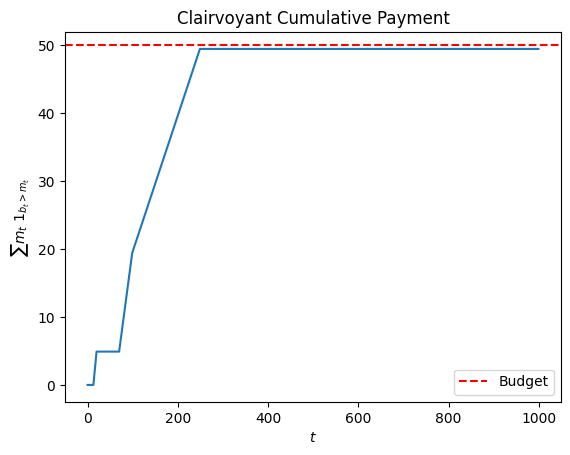

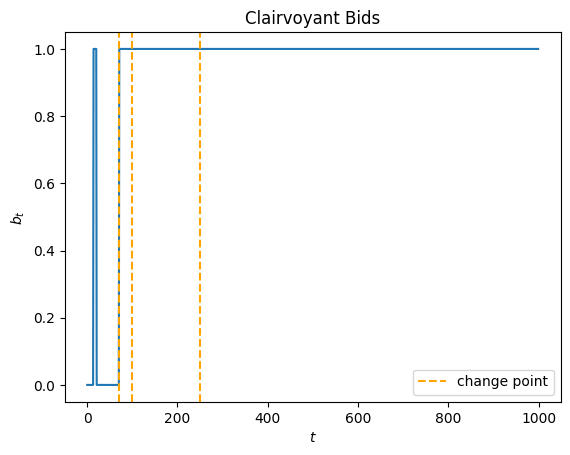

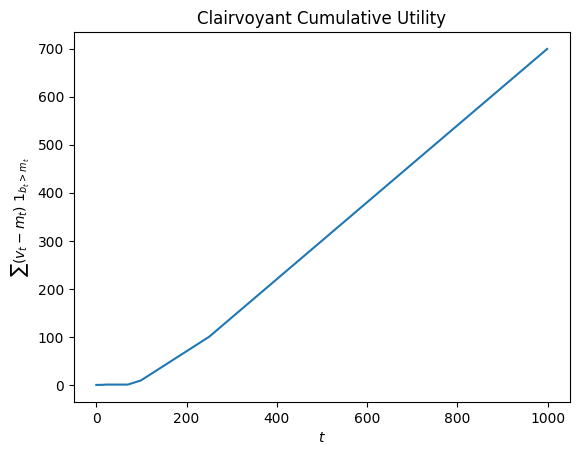

In [14]:
B = 50
ctr = 1
value_per_click = 0.8
my_valuation = ctr*value_per_click

# be careful: the function get_clairvoyant_truthful has been written assuming ctr=1
clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(B, my_valuation, m_t, n_users)

plt.title('Clairvoyant Cumulative Payment')
plt.plot(np.cumsum(clairvoyant_payments))
plt.axhline(B, color='red', linestyle='--', label='Budget')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$\sum m_t~ 1_{b_t > m_t}$')
plt.show()

plt.title('Clairvoyant Bids')
plt.plot(clairvoyant_bids)
plt.axvline(int(B/0.2), color='orange', linestyle='--', label='change point')
plt.axvline(int(B/0.5), color='orange', linestyle='--')
plt.axvline(int(B/0.7), color='orange', linestyle='--')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.show()

plt.title('Clairvoyant Cumulative Utility')
plt.plot(np.cumsum(clairvoyant_utilities))
plt.xlabel('$t$')
plt.ylabel('$\sum (v_t-m_t) ~ 1_{b_t > m_t}$')
plt.show()

#### The optimal policy makes the other bidders deplete their budgets first, and then exploits the auction as a unique bidder!

In [15]:
### Stochastic Bidders: my competitors sample their bids from 
### probability distributions

n_advertisers = 3
n_users = 1000
B = 50

# simple scenario: competitors sample bids from a uniform 
other_bids = np.random.uniform(0, 10*B/n_users, size = (n_advertisers, n_users))
# I assume that competitors may have a larger budget than mine (10*B), but they may
# not deplete it.

In [16]:
m_t = other_bids.max(axis=0) ### maximum bid at every round, NOT IN EXPECTATION
m_t[:10]

array([0.32221952, 0.32087025, 0.47874669, 0.2227548 , 0.48328284,
       0.3104164 , 0.18147946, 0.43344231, 0.45329732, 0.12314391])

#### I can, again, use the greedy strategy to find the clairvoyant's bids and utilities

<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
C:\Users\matteo\AppData\Local\Temp\ipykernel_15812\822385430.py:11: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum m_t~ 1_{b_t > m_t}$')


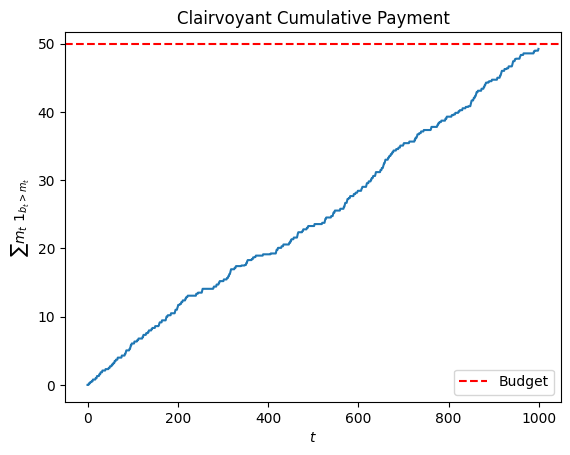

In [17]:
B = 50
my_valuation = 0.8

clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(B, my_valuation, m_t, n_users)

plt.title('Clairvoyant Cumulative Payment')
plt.plot(np.cumsum(clairvoyant_payments))
plt.axhline(B, color='red', linestyle='--', label='Budget')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$\sum m_t~ 1_{b_t > m_t}$')
plt.show();

#### What agent can I design without knowing all the information a priori?

### Budget Pacing

In [18]:
class MultiplicativePacingAgent:
    def __init__(self, valuation, budget, T, eta):
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.valuation/(self.lmbd+1)
    
    def update(self, f_t, c_t):
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t), 
                            a_min=0, a_max=1/self.rho)
        self.budget -= c_t

In [19]:
# advertisers' fixed parameters
## we assume that our agent has the FIRST index, e.g. our q_a*v_a = 0.56
n_advertisers = 4 # four advertisers, including myself
qs = np.ones(n_advertisers)
my_valuation = 0.8
B = 150

# environmental settings
n_users = 1000

# competitors
other_bids = np.random.uniform(0, 1, size = (n_advertisers-1, n_users))
m_t = other_bids.max(axis=0)
## I'm considering competitors stronger than me, since they are free to exceed my budget

clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(B, my_valuation, m_t, n_users)

In [20]:
eta = 1/np.sqrt(n_users) # from theory
agent = MultiplicativePacingAgent(valuation=my_valuation,
                                  budget=B,
                                  T=n_users, 
                                  eta=eta)

auction = SecondPriceAuction(qs)

utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

np.random.seed(18)
for u in range(n_users):
    # interaction
    my_bid = agent.bid()
    bids = np.append(my_bid, other_bids[:, u].ravel())
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(winners==0)
    f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
    agent.update(f_t, c_t)
    # logging
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins+=my_win
print(f'Total # of Wins: {total_wins}')

Total # of Wins: 255


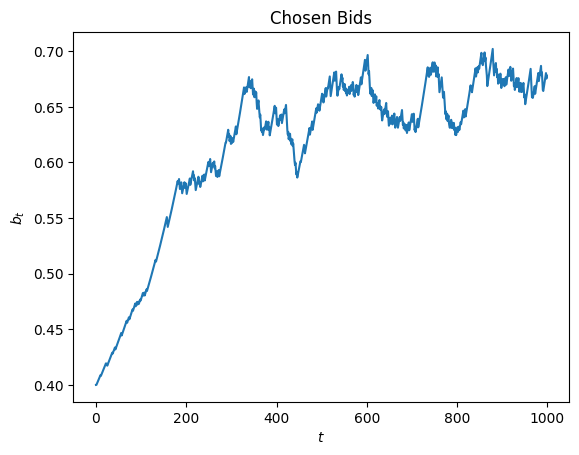

In [21]:
plt.plot(my_bids)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
C:\Users\matteo\AppData\Local\Temp\ipykernel_15812\4024054808.py:4: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum c_t$')


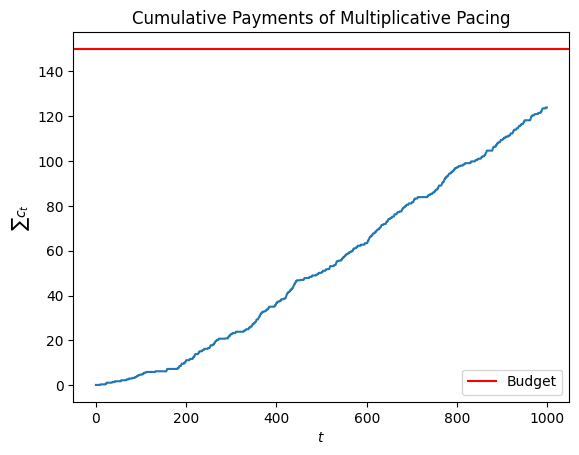

In [22]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
C:\Users\matteo\AppData\Local\Temp\ipykernel_15812\1594796484.py:4: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum f_t$')


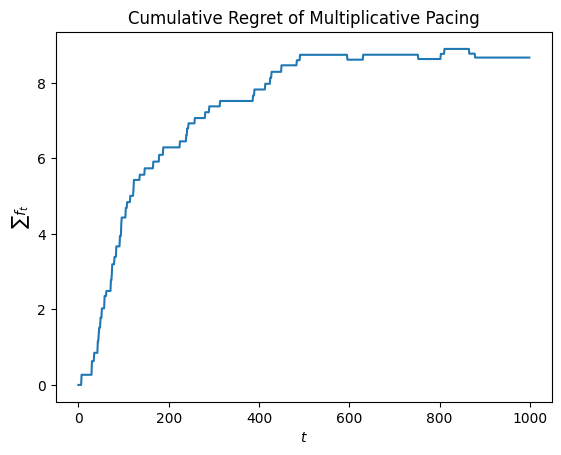

In [23]:
cumulative_regret = np.cumsum(clairvoyant_utilities-utilities)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum f_t$')
plt.title('Cumulative Regret of Multiplicative Pacing')
plt.show()

### This is one trial. As usual, we estiamte the regret empirically over multiple runs. 

<>:55: SyntaxWarning: invalid escape sequence '\s'
<>:55: SyntaxWarning: invalid escape sequence '\s'
C:\Users\matteo\AppData\Local\Temp\ipykernel_15812\3228418834.py:55: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum f^\star_t - f_t$')


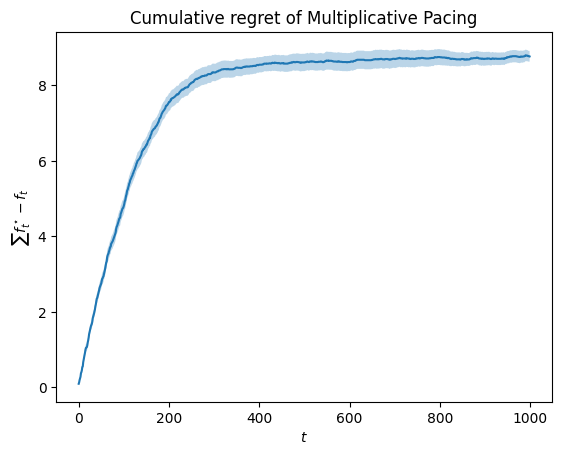

In [24]:
n_advertisers = 4
qs = np.ones(n_advertisers)
my_valuation = 0.8
B = 150

n_users = 1000

regret_per_trial = []

n_trials = 20

eta = 1/np.sqrt(n_users) # from theory
auction = SecondPriceAuction(qs)

np.random.seed(54)
for _ in range(n_trials):
    other_bids = np.random.uniform(0, 1, size = (n_advertisers-1, n_users))
    m_t = other_bids.max(axis=0)
    clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(B, my_valuation, m_t, n_users)

    agent = MultiplicativePacingAgent(valuation=my_valuation,
                                    budget=B,
                                    T=n_users, 
                                    eta=eta)

    agent_utilities = []

    for u in range(n_users):
        # interaction
        my_bid = agent.bid()
        bids = np.append(my_bid, other_bids[:, u].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(winners==0)
        f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
        agent.update(f_t, c_t)
        # logging
        agent_utilities.append(f_t)

    cumulative_regret = np.cumsum(clairvoyant_utilities-agent_utilities)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

avg_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(n_users), avg_regret, label='Average Regret')
plt.title('Cumulative regret of Multiplicative Pacing')
plt.fill_between(np.arange(n_users),
                avg_regret-regret_sd/np.sqrt(n_trials),
                avg_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.ylabel('$\sum f^\star_t - f_t$')
plt.show()

## Adversarial bidders

### If the bidders are adversarial, no algorithm can achieve more than $\rho \text{OPT}$, 
### where $\rho=B/T$, in the worst case.

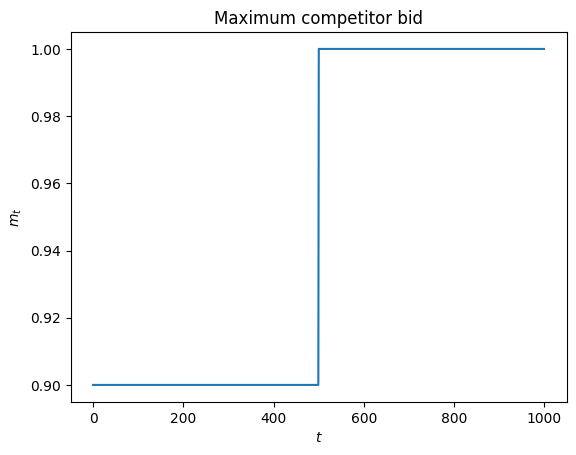

In [97]:
n_users = 1000
B = 500
rho = B / n_users
qs = np.ones(2)

m_t = np.repeat(0.9, n_users)
m_t[int(n_users/2):] = 1

# m_t = np.repeat(0.9, n_users)
# m_t[int(n_users/2):] = 0.8

my_valuation = 1
plt.plot(np.arange(n_users), m_t)
plt.title('Maximum competitor bid')
plt.xlabel('$t$')
plt.ylabel('$m_t$')
plt.show()

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
C:\Users\matteo\AppData\Local\Temp\ipykernel_15812\442043143.py:6: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$b^\star_t$')


OPT=50.0


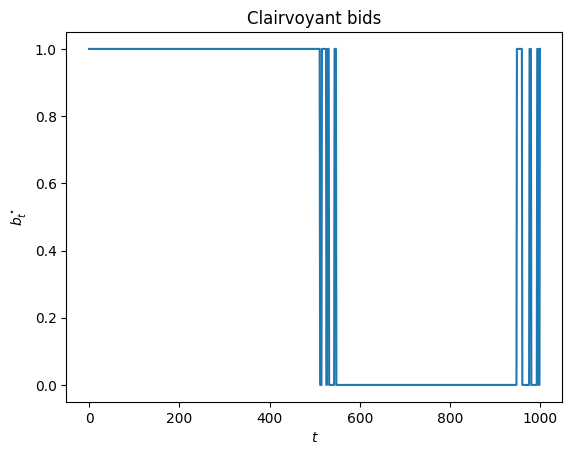

In [100]:
clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(B, my_valuation, m_t, n_users)
print(f'OPT={np.sum(clairvoyant_utilities)}')
plt.plot(np.arange(n_users), clairvoyant_bids)
plt.title('Clairvoyant bids')
plt.xlabel('$t$')
plt.ylabel('$b^\star_t$')
plt.show()

In [101]:
eta = 1/np.sqrt(n_users) # from theory
agent = MultiplicativePacingAgent(valuation=my_valuation,
                                  budget=B,
                                  T=n_users, 
                                  eta=eta)

auction = SecondPriceAuction(qs)

utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

np.random.seed(18)
for u in range(n_users):
    # interaction
    my_bid = agent.bid()
    bids = np.append(my_bid, m_t[u])
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(winners==0)
    f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
    agent.update(f_t, c_t)
    # logging
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins+=my_win
print(f'Total # of Wins: {total_wins}')
print(f'Cumulative utility: {np.sum(utilities)}')
print(f'OPT*B/t: {np.sum(clairvoyant_utilities)*rho}')

Total # of Wins: 246
Cumulative utility: 24.599999999999994
OPT*B/t: 25.0


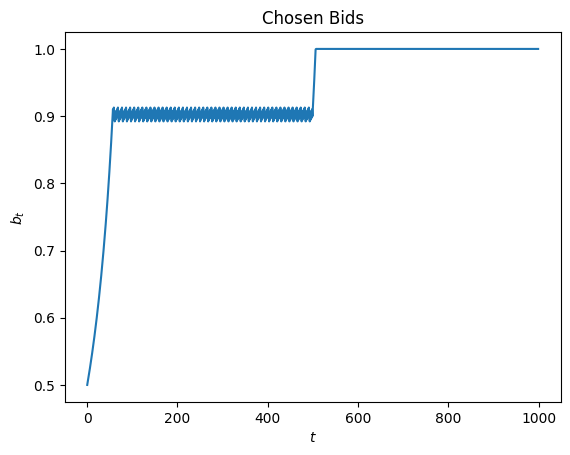

0.5


In [103]:
plt.plot(my_bids)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()
print(my_bids[0])